In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
%matplotlib inline

from collections import Counter

import catboost as CatBoosClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, GroupShuffleSplit,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from IPython.display import HTML
import pandas as pd
import numpy as np
import base64


In [27]:
print(os.listdir('../input/machinehack/MetalFurnace-Participants_Data'))

['Test.csv', 'Sample_Submission.xlsx', 'Train.csv']


# Reading Data

In [28]:
train_1 = pd.read_csv('../input/machinehack/MetalFurnace-Participants_Data/Train.csv')
test_1 = pd.read_csv('../input/machinehack/MetalFurnace-Participants_Data/Test.csv')
train = train_1.copy()
test = test_1.copy()
print(f"Train Shape {train.shape}\t Test Shape {test.shape}")

Train Shape (620, 29)	 Test Shape (266, 28)


In [29]:
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,grade
0,1.848564,-0.26425,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,0.443257,-0.406121,-0.687687,0.271886,3.727218,0.102129,2
1,-0.825098,-0.26425,3.032397,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,-0.232546,-0.406366,-0.687687,0.271886,-0.232472,0.102129,4
2,1.848564,-0.26425,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,1.459782,1.221876,1.877777,0.271886,-0.232472,0.102129,2
3,0.511733,-0.26425,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,-0.008030,-0.406366,1.504523,0.271886,-0.232472,0.102129,2
4,-0.825098,-0.26425,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,-0.573268,-1.164793,1.877777,0.271886,-0.232472,0.102129,2


In [30]:
# train[train.columns.to_list()].corr()

# EDA on Features 
Now First I am are going to visualize the variance of each feature towards our final target grade

In [31]:
from sklearn.decomposition import PCA
pca=PCA()
temp_df = train.copy()
temp_df = pca.fit_transform(temp_df)
print(pca.explained_variance_ratio_)

[1.19732853e-01 8.44410258e-02 7.03374625e-02 6.68620875e-02
 5.84914941e-02 5.34702892e-02 4.26459051e-02 4.19319586e-02
 3.86892895e-02 3.81069650e-02 3.77186982e-02 3.67878293e-02
 3.47935294e-02 3.29282170e-02 3.18074362e-02 2.89426316e-02
 2.73526709e-02 2.57598984e-02 2.23608108e-02 2.14236560e-02
 1.84043386e-02 1.62712726e-02 1.29695497e-02 1.15727179e-02
 1.00723267e-02 7.72594644e-03 5.04163064e-03 3.35750972e-03
 4.78603388e-34]


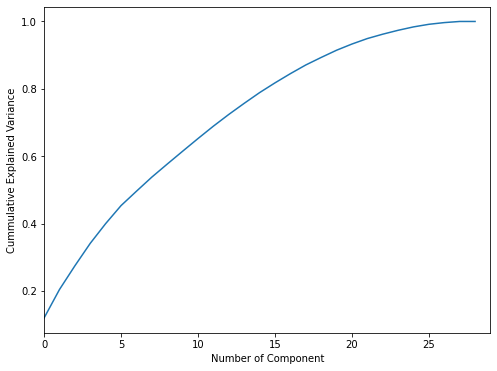

In [32]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,29,1)
plt.xlabel('Number of Component')
plt.ylabel('Cummulative Explained Variance')
plt.show()
x=np.cumsum(pca.explained_variance_ratio_)

It Shows that variance is approximately directly proportional to number of components.

So, we take feature upto f23 

In [33]:
delete = ['f24','f25','f26','f27']
for i in delete:
    del train[i]

In [34]:
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,grade
0,1.848564,-0.26425,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.098853,0.308879,0.040193,0.182574,0.085505,0.233285,-1.080663,0.443257,-0.406121,2
1,-0.825098,-0.26425,3.032397,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.098853,0.308879,0.040193,0.182574,0.085505,0.233285,-1.080663,-0.232546,-0.406366,4
2,1.848564,-0.26425,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.098853,0.308879,0.040193,0.182574,0.085505,0.233285,0.925358,1.459782,1.221876,2
3,0.511733,-0.26425,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.098853,-3.237512,0.040193,0.182574,0.085505,0.233285,0.925358,-0.008030,-0.406366,2
4,-0.825098,-0.26425,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.098853,0.308879,0.040193,0.182574,0.085505,0.233285,0.925358,-0.573268,-1.164793,2


# EDA on Target

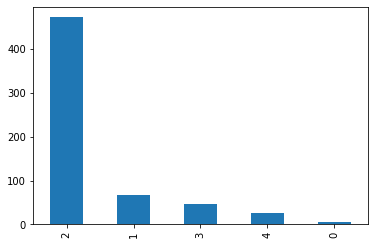

In [35]:
train.grade.value_counts().plot(kind='bar')

# WOOOOOOHHHHHOOOOOOO
We got the problem it is IMBALANCE MULTI-CLASS PROBLEM. So, to minimize this affect we going generate ramdom sample of class 1,3,4,0.

# IMBALANCED-LEARNING
Now, Their are many ways in which you can deal with imbalance class and trust me i tried all of them. After trying all of them i came up with 3 best techniques 
1. Random Sampler
Random oversampling simply replicates randomly the minority class examples. Random oversampling is known to increase the likelihood of occurring overfitting. On the other hand, the major drawback of Random undersampling is that this method can discard useful data.
2. SMOTE
To avoid the over-fitting problem, Chawla et al. (2002) propose the Synthetic Minority Over-sampling Technique (SMOTE). This method is considered a state-of-art technique and works well in various applications. This method generates synthetic data based on the feature space similarities between existing minority instances. In order to create a synthetic instance, it finds the K-nearest neighbors of each minority instance, randomly selects one of them, and then calculate linear interpolations to produce a new minority instance in the neighborhood.
3. ADASYN
ADASYN generates samples of the minority class according to their density distributions. More synthetic data is generated for minority class samples that are harder to learn, compared to those minority samples that are easier to learn. It calculates the K-nearest neighbors of each minority instance, then gets the class ratio of the minority and majority instances to generate new samples. By repeating this process, it adaptively shifts the decision boundary to focus on those samples that are difficult to learn.

#### You Find Some more Reference in https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879 

In [36]:
feat = train.columns.to_list()
target='grade'
feat.remove(target)

In [37]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=13,sampling_strategy='all')
X_train_ovr,y_train_ovr = sm.fit_sample(train[feat],train[target])
print(X_train_ovr.shape)

Using TensorFlow backend.


(2360, 24)


In [38]:
train_ovr = pd.DataFrame(X_train_ovr,columns=feat)
train_ovr[target] = y_train_ovr

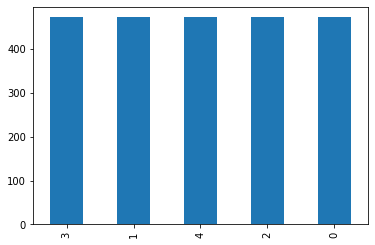

In [40]:
train_ovr.grade.value_counts().plot(kind='bar')

XD We made this .....hurrreeeeeyyyyyyyyyyy

# Training Model

In [50]:
def splitter(train, features, target, ts=False):
    if ts:
        trainX, validX, trainY, validY = train_test_split(train[features],
                                                          train[target], test_size=0.2,
                                                          random_state=13, shuffle=False)
    else:
        trainX, validX, trainY, validY = train_test_split(train[features],
                                                      train[target], test_size=0.2,
                                                      random_state=13)
    return trainX, validX, trainY, validY

def lgb_model(train, test, features, target, ts=False):
    evals_result = {}
    trainX, validX, trainY, validY = splitter(train, features, target, ts=ts)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 2000
    lgb_params = {
#         "boosting": 'gbdt',  # "dart",
        "num_class":5,
#         "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "multiclass",
        "metric": "multi_logloss",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=50,
        verbose_eval=100,
        evals_result=evals_result,
    )

    lgb.plot_importance(lgb_model, figsize=(24, 24))
    lgb.plot_metric(evals_result, metric='multi_logloss')
    
    preds = lgb_model.predict(test[feat])
    return lgb_model, preds

LGB Model
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.00412878	valid_1's multi_logloss: 0.00973756
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.00310917	valid_1's multi_logloss: 0.00716716


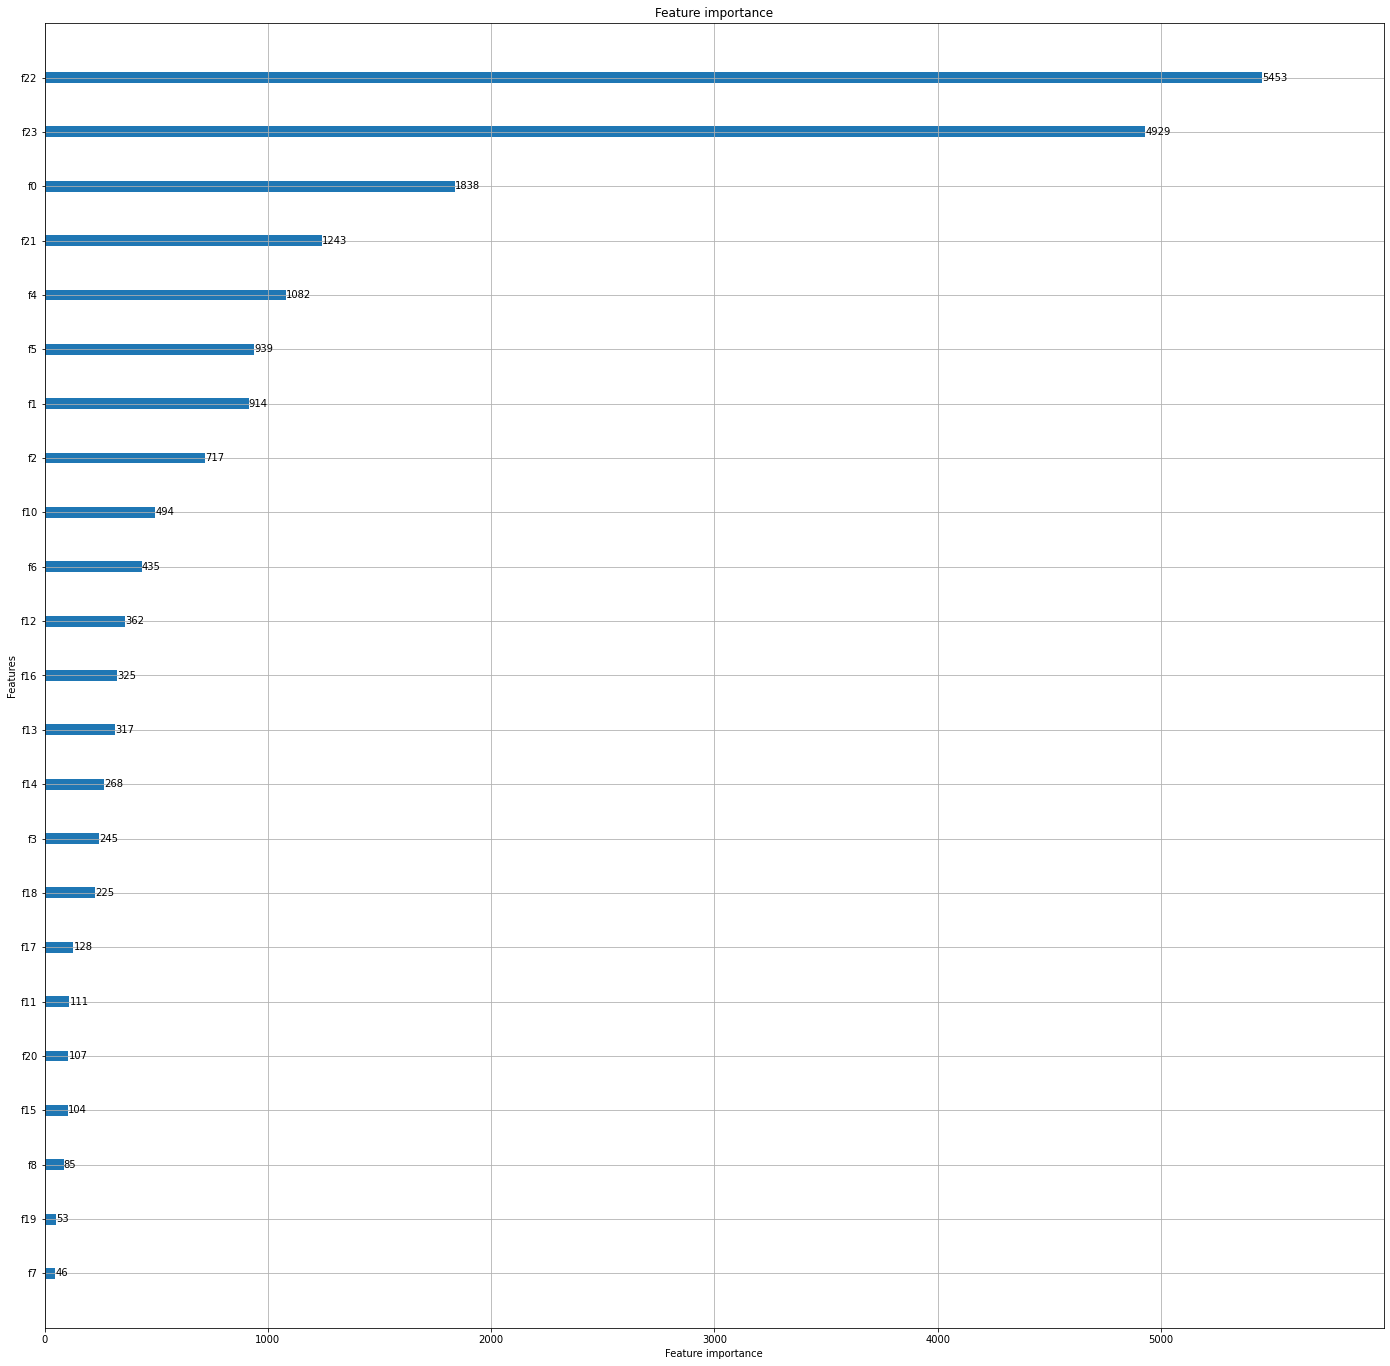

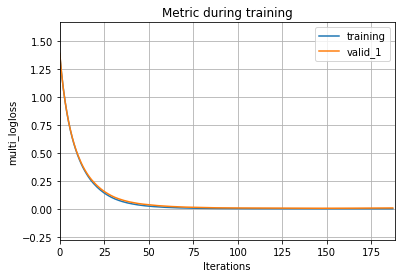

In [51]:
lgbM, lgb_preds = lgb_model(train_ovr, test, feat, target, ts=False)

In [54]:
pred = lgbM.predict(test[feat])
sub = pd.DataFrame(pred)
sub.to_excel("final.xlsx",index=False)